Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
MSE:  0.45364666769191586
RMSE:  0.6735329744651822
{'max_depth': 10, 'min_samples_split': 10}
Mean cross-validated score:  0.42620041228623684


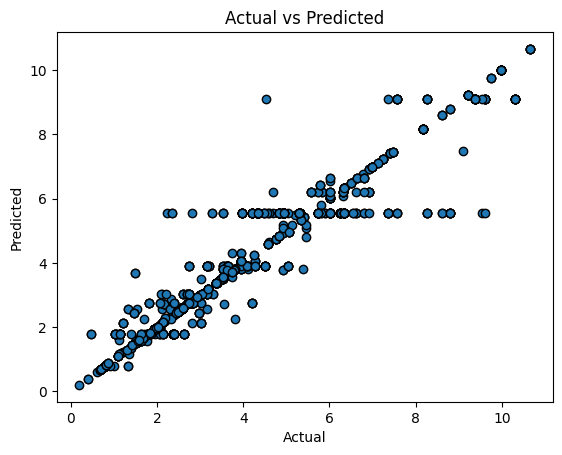

In [ ]:
"""
ANALYSIS DELIVERABLE
MACHINE LEARNING COMPONENT: Decision Tree Regressor Model
AUTHORS: Mike + Sarah
"""

# Independent variables: Latitude, Longitude, Current Average Temperature (dC)_area_weighted, Current Average Temperature_point_coordinate (dC), Current Annual Precipitation (mm) _area_weighted etc.
# Dependent variables: Crop Yield 
# Model: Decision Tree Regressor, because it is a regression problem and the data is continuous
# Goal: Build a machine learning model that predicts the yield of 3 crops (rice, maize and wheat) based on climate data

# Categorical values: Country, Crop --> one hot encoding to convert to numeric values
# Split the dataset into training and testing (training dataset up to a certain year)
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from google.colab import drive
drive.mount('/content/drive/')

# read in the csv data as a data frame
# 57 unique countries, 19 years
crop_df = pd.read_csv("/content/drive/My Drive/Data Science: Food Security/data/faostat_projected.csv", encoding='latin-1')

# drop irrelevant columns for the analysis
crop_df = crop_df.drop(["Region", "latitude", "longitude", "Future_Mid-point", "Climate scenario", "Scenario source",
                        "Local delta T from 2005", "Global delta T from 2005",
                        "Projected yield (t/ha)", "Climate impacts (%)", "Climate impacts relative to 2005", "Climate impacts per dC (%)",
                        "Climate impacts per decade (%)", "CO2", "Adaptation type", "Seasonal Precipitation change (mm) each study (local baseperiod)",
                        "Base precipitation (annual) (mm) (local base period)",
                        "Annual Preciptation change (%) (relative to local base)",
                        "Base precipitation (seasonal) (mm) (local base period)", "Planting time", "Others"
                        ], axis=1)

# drop any empty rows from dataset
crop_df = crop_df.dropna()

# drop duplicate rows
crop_df = crop_df.drop_duplicates(subset=None, keep="first", inplace=False)

# convert the Yes/No values to 1/0 / convert categorical variables to numeric values
columns_to_transform = ["Fertiliser", "Irrigation", "Cultivar", "Soil organic matter management", "Tillage", "Adaptation"]
for col in columns_to_transform:
  crop_df[col] = crop_df[col].map({"Yes": 1, "No": 0})

# encode categorical variables with one hot encoding: Country and Crop
crop_df_onehot = pd.get_dummies(crop_df, columns=['Country',"Crop"], prefix = ['Country',"Crop"])
crop_df = crop_df.drop(["Country", "Crop"], axis=1)
crop_df = pd.concat([crop_df, crop_df_onehot], axis=1)

# drop duplicate columns
crop_df = crop_df.T.drop_duplicates().T

# get the features and label for the model
features=crop_df_onehot.loc[:, crop_df_onehot.columns != 'Yield']
label=crop_df.loc[:, "Yield"]

# make sure to drop Year because it's not a feature
features = features.drop(['Year'], axis=1)

# scale features to make sure they have the same level of magnitudes
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# split dataset into training and testing data
train_data, test_data, train_labels, test_labels = train_test_split(features, label, test_size=0.2, random_state=42)

# create test data set
crop_df_onehot = crop_df_onehot.drop(['Year'], axis=1)
# create a dataframe with the one-hot encoded values
test_df = pd.DataFrame(test_data, columns=crop_df_onehot.loc[:, crop_df_onehot.columns != 'Yield'].columns) 
# get the country and crop values from the one-hot encoded values
cntry = test_df[[col for col in test_df.columns if 'Country' in col]].stack()[test_df[[col for col in test_df.columns if 'Country' in col]].stack()>0]
# get the country values from the one-hot encoded values
cntrylist = list(pd.DataFrame(cntry).index.get_level_values(1))
countries = [i.split("_")[1] for i in cntrylist]
# get the crop values from the one-hot encoded values
crp = test_df[[col for col in test_df.columns if 'Crop' in col]].stack()[test_df[[col for col in test_df.columns if 'Crop' in col]].stack()>0]
crplist=list(pd.DataFrame(crp).index.get_level_values(1))
crops=[i.split("_")[1] for i in crplist]

# convert one-hot encoded values back to actual country and crop values for testing purpose
test_df.drop([col for col in test_df.columns if 'Crop' in col],axis=1,inplace=True)
test_df.drop([col for col in test_df.columns if 'Country' in col],axis=1,inplace=True)
test_df['Country']=countries
test_df['Crop']=crops
test_df.head()

# train decision tree regressor; the hyperparameters are chosen through the Grid Search Method with k-fold cross validation
clf = DecisionTreeRegressor(max_depth=10,
                                  min_samples_split=10)
model = clf.fit(train_data, train_labels)

# test the predicted values against the actual values for the test data
test_df["yield_predicted"]= model.predict(test_data)
test_df["yield_actual"]=pd.DataFrame(test_labels)["Yield"].tolist()
test_group=test_df.groupby("Crop")

# measure the accuracy of the decision tree regressor model by calculating the mse and rmse
mse = mean_squared_error(test_df["yield_actual"], test_df["yield_predicted"])

# The rmse has the same unit as the dependent variable. In this case, since the dependent variable Yield has a range of 0.2035743298 to 10.65696568,
# which are small values. This could explain why the mse and rmse are both very low.
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0)) 

# Grid Search method with K-Fold Cross Validation (https://towardsdatascience.com/train-a-regression-model-using-a-decision-tree-70012c22bcc1)
gs = GridSearchCV(model,
                  param_grid = {'max_depth': range(1, 11),
                                'min_samples_split': range(10, 60, 10)},
                  cv=5,
                  n_jobs=1,
                  scoring='neg_mean_squared_error')

gs.fit(train_data, train_labels)

# find the best params given by the Grid Search with k-fold cross validation
print(gs.best_params_)

# Mean cross-validated score of the best_estimator
print("Mean cross-validated score: ", -gs.best_score_)

# dt_scores = cross_val_score(model, train_data, train_labels, cv = 5)
# print("mean cross validation score: {}".format(np.mean(dt_scores)))
# print("score without cv: {}".format(model.score(train_data, train_labels)))

# dt_scores_testing = cross_val_score(model, test_data, test_labels, cv = 5)
# print("mean cross validation score test: {}".format(np.mean(dt_scores_testing)))

# # R2 score on the test dataset
# print(model.score(test_data, test_labels))

# ***MODEL SELECTION & VISUALIZATION HELPER FUNCTIONS***

# compare the R2 score of different models to find the best model for the given task. 
# The R2 (coefficient of determination) shows how well terms (data points) fit a curve or line. R^2 is a statistical measure between 0 and 1 which calculates how similar a regression line is to the data it’s fitted to. 
# If it’s a 1, the model 100% predicts the data variance; if it’s a 0, the model predicts none of the variance.
# Based on the results, Decision Tree Regressor produced the highest R2 score out of all the models. The R2 score is 0.998.
# This means that Decision Tree Regressor is the most fitting model for this task. 

# helper function for comparing the R2 score of different prediction models
# def compare_models(model):
#     model_name = model.__class__.__name__
#     fit=model.fit(train_data,train_labels)
#     y_pred=fit.predict(test_data)
#     r2=r2_score(test_labels,y_pred)
#     return([model_name,r2])
# models = [
#     GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=0),
#      RandomForestRegressor(n_estimators=200, max_depth=3, random_state=0),
#     svm.SVR(),
#    DecisionTreeRegressor()
# ]

# model_train=list(map(compare_models,models)) 
# print(*model_train, sep = "\n")

# Visualize the correlation matrix of the columns as a heat map
# crop_df_heatmap = crop_df.drop(['Year'], axis=1)
# correlation_data=crop_df_heatmap.select_dtypes(include=[np.number]).corr()

# mask = np.zeros_like(correlation_data, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
# cmap = sns.palette="vlag"

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(correlation_data, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

# plt.title("Correlation between columns in the Faostat Projected Dataset")
# plt.show()


# crop_df.groupby(['Crop', "Country"],sort=True)['Yield'].sum().nlargest(10)
# crop_df.head()

# Plot the Actual vs. Predicted values
# fig, ax = plt.subplots() 

# ax.scatter(test_df["yield_actual"], test_df["yield_predicted"], edgecolors=(0, 0, 0))

# ax.set_xlabel('Actual')
# ax.set_ylabel('Predicted')
# ax.set_title("Actual vs Predicted for Decision Tree Regressor on Faostat Projected Dataset")
# plt.show()